# **1. FLOW AND VI**

In [1]:
import jax
import jax.numpy as jnp
import equinox

from flowjax.bijections import (
    Affine as AffinePositiveScale,
    Chain,
    Exp,
    Identity,
    Stack,
    Tanh,
)
from flowjax.distributions import StandardNormal, Transformed
from flowjax.flows import block_neural_autoregressive_flow
from paramax.wrappers import non_trainable


class Flow:
    def __init__(self, bounds=None):
        self.bounds = bounds

    @staticmethod
    def Affine(loc=0, scale=1):
        affine = AffinePositiveScale(loc, scale)
        loc, scale = jnp.broadcast_arrays(
            affine.loc, jnp.asarray(scale, dtype=float),
        )
        affine = equinox.tree_at(lambda tree: tree.scale, affine, scale)
        return affine

    @staticmethod
    def Logistic(shape=()):
        loc = jnp.ones(shape) * 0.5
        scale = jnp.ones(shape) * 0.5
        return Chain([Tanh(shape), Flow.Affine(loc, scale)])

    @staticmethod
    def UnivariateBounder(bounds=None):
        # no bounds
        if (bounds is None) or all(bound is None for bound in bounds):
            return Identity()

        # bounded on one side
        elif any(bound is None for bound in bounds):
            # bounded on right-hand side
            if bounds[0] is None:
                loc = bounds[1]
                scale = -1
            # bounded on left-hand side
            elif bounds[1] is None:
                loc = bounds[0]
                scale = 1
            return Chain([Exp(), Flow.Affine(loc, scale)])

        # bounded on both sides
        else:
            loc = bounds[0]
            scale = bounds[1] - bounds[0]
            return Chain([Flow.Logistic(), Flow.Affine(loc, scale)])

    def Bounder(self):
        return Stack(list(map(self.UnivariateBounder, self.bounds)))

    def bound_from_unbound(self, flow):
        bounder = self.Bounder()

        if all(type(b) is Identity for b in bounder.bijections):
            bijection = flow.bijection
        else:
            bijection = Chain([flow.bijection, non_trainable(bounder)])

        return Transformed(non_trainable(flow.base_dist), bijection)

    def default_flow(self, key, **kwargs):
        default_kwargs = dict(
            key=key,
            base_dist=StandardNormal(shape=(len(self.bounds),)),
            invert=False,
            nn_depth=1,
            nn_block_dim=16,
            flow_layers=1,
        )

        for arg in kwargs:
            default_kwargs[arg] = kwargs[arg]

        flow = block_neural_autoregressive_flow(**default_kwargs)

        return self.bound_from_unbound(flow)




import sys
import time
import tqdm

import jax
import jax.numpy as jnp
import jax_tqdm
import equinox
import optax

from flowjax.distributions import Uniform
from paramax.wrappers import NonTrainable


class VI:

    def __init__(self, prior_bounds, likelihood=None):
        self.prior_bounds = prior_bounds
        self.likelihood = likelihood

    def get_prior(self, bounds):
        lo = jnp.array(bounds)[:, 0]
        hi = jnp.array(bounds)[:, 1]
        return Uniform(minval=lo, maxval=hi)

    def get_log_likelihood(self, likelihood=None, return_variance=False):
        if likelihood is None:
            if return_variance:
                return lambda parameters: (0.0, 0.0)
            return lambda parameters: 0.0

        if return_variance:
            def log_likelihood_and_variance(parameters):
                likelihood.parameters.update(parameters)
                return likelihood.ln_likelihood_and_variance()

            return log_likelihood_and_variance

        def log_likelihood(parameters):
            likelihood.parameters.update(parameters)
            return likelihood.log_likelihood_ratio()

        return log_likelihood

    def likelihood_extras(self, likelihood, parameters):
        likelihood.parameters.update(parameters)
        likelihood.parameters, added_keys = likelihood.conversion_function(
            likelihood.parameters,
        )
        likelihood.hyper_prior.parameters.update(parameters)

        log_bayes_factors, variances = \
            likelihood._compute_per_event_ln_bayes_factors()

        detection_efficiency, detection_variance = \
            likelihood.selection_function.detection_efficiency(parameters)

        selection = -likelihood.n_posteriors * jnp.log(detection_efficiency)
        selection_variance = (
            likelihood.n_posteriors ** 2
            * detection_variance
            / detection_efficiency ** 2
        )

        log_likelihood = jnp.sum(log_bayes_factors) + selection
        variance = jnp.sum(variances) + selection_variance

        return dict(
            log_likelihood=log_likelihood,
            variance=variance,
            log_bayes_factors=log_bayes_factors,
            variances=variances,
            detection_efficiency=detection_efficiency,
            detection_variance=detection_variance,
            selection=selection,
            selection_variance=selection_variance,
        )

    def trainer(
        self,
        key,
        vmap=True,
        flow=None,
        batch_size=None,
        steps=None,
        learning_rate=None,
        optimizer=None,
        taper=None,
        temper_schedule=None,
        **tqdm_kwargs,
    ):
        print('GWAX - getting ready...')

        names = tuple(self.prior_bounds.keys())
        bounds = tuple(self.prior_bounds.values())
        prior = self.get_prior(bounds)

        _log_likelihood_and_variance = self.get_log_likelihood(self.likelihood, True)
        if vmap:
            log_likelihood_and_variance = jax.vmap(_log_likelihood_and_variance)
        else:
            log_likelihood_and_variance = lambda parameters: jax.lax.map(
                _log_likelihood_and_variance, parameters,
            )

        if taper is None:
            taper = lambda variance: 0.0

        def log_target(samples):
            parameters = dict(zip(names, samples.T))
            log_lkls, variances = log_likelihood_and_variance(parameters)
            return prior.log_prob(samples) + log_lkls + taper(variances)

        if flow is None:
            key, _key = jax.random.split(key)
            flow = Flow(bounds=bounds).default_flow(_key)  

        params, static = equinox.partition(
            pytree=flow,
            filter_spec=equinox.is_inexact_array,
            is_leaf=lambda leaf: isinstance(leaf, NonTrainable),
        )

        def loss_fn(params, key, step):
            flow = equinox.combine(params, static)
            samples, log_flows = flow.sample_and_log_prob(key, (batch_size,))
            log_targets = log_target(samples) * temper_schedule(step)
            return jnp.mean(log_flows - log_targets)

        if optimizer is None:
            optimizer = optax.adam
        if callable(optimizer):
            optimizer = optimizer(learning_rate)

        state = optimizer.init(params)

        if temper_schedule is None:
            temper_schedule = lambda step: 1.0

        tqdm_defaults = dict(
            print_rate=1,
            tqdm_type='auto',
            desc='GWAX - variational training',
        )
        for arg in tqdm_kwargs:
            tqdm_defaults[arg] = tqdm_kwargs[arg]

        @jax_tqdm.scan_tqdm(steps, **tqdm_defaults)
        @equinox.filter_jit
        def update(carry, step):
            key, params, state = carry
            key, _key = jax.random.split(key)
            loss, grad = equinox.filter_value_and_grad(loss_fn)(params, _key, step)
            updates, state = optimizer.update(grad, state, params)
            params = equinox.apply_updates(params, updates)
            return (key, params, state), loss

        print('GWAX - JAX jitting...')
        t0 = time.time()
        (key, params, state), losses = jax.lax.scan(
            update, (key, params, state), jnp.arange(steps),
        )
        flow = equinox.combine(params, static)
        print(f'GWAX: Total time = {time.time() - t0} s')

        return flow, losses
    



# packages for diagnostics
import optax
import jax
from jax import random
import numpy as np
import corner 
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
import jax.numpy as jnp



c:\Users\oleks\miniconda3\envs\GRASP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **2. Gaussian mixture likelihood**

In [2]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp


class GaussianMixtureLikelihood:
    """
    Log-likelihood for a fixed Gaussian mixture 

    Args
    ----
    means        : (K, D) array component means 
    covs         : (K, D, D) array component covariances (positive semi-definite)
    weights      : (K,) array of normalised weights 
    """

    def __init__(self, means, covs, weights):
        self.means    = jnp.asarray(means)
        self.covs     = jnp.asarray(covs)
        # put weights in simplex so that they sum up to 1
        self.log_w    = jax.nn.log_softmax(jnp.asarray(weights))
        # K = nr of components, D = nr of dimensions
        self.K, self.D = self.means.shape
        self.parameters = {f"x{i}": 0.0 for i in range(self.D)}

        # normalising constant of a multivariate Gaussian (pdf integrate to 1)
        self.cov_invs  = jax.vmap(jnp.linalg.inv)(self.covs)                          # (K, D, D)
        self.log_dets  = jax.vmap(lambda C: jnp.linalg.slogdet(C)[1])(self.covs)      # (K,)
        # function
        self.log_norms = -0.5 * (self.D * jnp.log(2.0 * jnp.pi) + self.log_dets)      # (K,)


    def update(self, new_params):
        """Current evaluation sample x."""
        self.parameters = new_params

    def ln_likelihood_and_variance(self):
        """Return log p(x) and a dummy variance. It was given by definition"""
        x = jnp.array(list(self.parameters.values()))
        logp = self._log_prob(x)
        var  = 0.0  
        return logp, var

    
    #  log-pdf                                                             
    def _log_prob(self, x):
        """
        Numerically-stable log p(x):
            log Σ_k w_k 𝒩_k(x)
        implemented as logsumexp(log w_k + log 𝒩_k(x)).
        """
        def one_component(mu, cov_inv, log_norm):
            diff = x - mu
            quad = diff @ cov_inv @ diff
            return log_norm - 0.5 * quad                         # log 𝒩_k(x | μ, Σ)
        
        # make a mixture
        log_comp = jax.vmap(one_component)(self.means,
                                           self.cov_invs,
                                           self.log_norms)
        log_mix  = logsumexp(self.log_w + log_comp)              # log Σ_k w_k ...
        return log_mix



# **3. True Gaussian sampler** 

In [3]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import corner


"""The following can be used to improve plotting a bit"""
params = {
        "text.usetex" : False,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16
}

plt.rcParams.update(params)

# Improved corner kwargs -- pass them to corner.corner
default_corner_kwargs = dict(bins=50, 
                        smooth=1.0, 
                        show_titles=False,
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        color="blue",
                        # quantiles=[],
                        # levels=[0.9],
                        plot_density=True, 
                        plot_datapoints=False, 
                        fill_contours=True,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        truth_color = "red",
                        save=False)

"""Now for the main function"""

def generate_gaussian_mixture(n_dim: int,
                              n_gaussians: int = 3,
                              n_samples: int = 10_000,
                              means: list = None,
                              covariances: list = None,
                              weights: list = None,
                              width_mean: float = 12.0,
                              width_cov: float = 3.0):
    """
    Generate samples from a mixture of Gaussians. 
    This function generates samples from a Gaussian mixture model with specified means, covariances, and weights.
    If means, covariances, or weights are not provided, they are generated randomly.
    
    Args:
        n_dim (int): The number of dimensions for the samples.
        n_gaussians (int, optional): The number of Gaussian components in the mixture. Defaults to 1.
        n_samples (int, optional): The number of samples to generate. Defaults to 10,000.
        means (list, optional): The mean vectors. If not specified, then they will be generated randomly. Defaults to None.
        covariances (list, optional): The square covariance matrix of size (n_dim x n_dim). If not specified, then they will be generated randomly. Defaults to None.
        weights (list, optional): Weights between the different Gaussians. If not specified, equal weights are used. Defaults to None.
        width_mean (float, optional): The width of the mean distribution. Defaults to 10.0.
        width_cov (float, optional): The width of the covariance distribution. Defaults to 1.0.
    """
    
    # If no mean vector is given, generate random means
    seed = np.random.randint(0, 1000)
    jax_key = jax.random.PRNGKey(seed)
    if means is None:
        means = []
        for _ in range(n_gaussians):
            # Split the key to ensure different means for each Gaussian
            jax_key, subkey = jax.random.split(jax_key)
            this_means = jax.random.uniform(subkey, (n_dim,), minval=-width_mean, maxval=width_mean)
            print("this_means")
            print(this_means)
            
            means.append(this_means)
    print(f"Means: {means}")
        
    # If no covariance matrix is given, generate identity matrices
    if covariances is None:
        covariances = []
        for _ in range(n_gaussians):
            jax_key, subkey = jax.random.split(jax_key)
            A = jax.random.uniform(subkey, (n_dim, n_dim), minval=-width_cov, maxval=width_cov)
            B = jnp.dot(A, A.transpose())
            covariances.append(B)
    print(f"Covariances: {covariances}")
    
    # If no weights are given, use equal weights between the Gaussians
    if weights is None:
        weights = [1.0 / n_gaussians] * n_gaussians
    print(f"Weights: {weights}")
        
    # Check if everythingq is consistent
    if len(means) != n_gaussians or len(covariances) != n_gaussians or len(weights) != n_gaussians:
        raise ValueError("Means, covariances, and weights must match the number of Gaussians.")
    
    # Generate samples
    samples = []
    for i in range(n_samples):
        # Choose a Gaussian component based on weights
        this_key = jax.random.PRNGKey(i)
        this_key, sample_key = jax.random.split(this_key)
        component = np.random.choice(n_gaussians, p=weights)
        mean = means[component]
        covariance = covariances[component]
        
        # Generate a sample from the chosen Gaussian
        sample = jax.random.multivariate_normal(sample_key, mean, covariance)
        samples.append(sample)
        
    samples = jnp.array(samples)
    return samples, means, covariances, weights

# **4. Defining parameters for VI trainer**

In [4]:
import jax.numpy as jnp
from jax import random
np.random.seed(2)


# generate true samples and parameters
true_samples, means, covariances, weights = generate_gaussian_mixture(n_dim=3,
                                                                      n_gaussians = 3)

# same parameters (means, covariances and weights for VI trainer)
vi_means   = jnp.asarray(means)        
vi_covs    = jnp.asarray(covariances)  
vi_weights = jnp.asarray(weights)      

print(vi_means.shape)   
print(vi_covs.shape)    
print(vi_weights.shape)  

key = random.key(0)


# likelihood function  
likelihood = GaussianMixtureLikelihood(vi_means,
                                       vi_covs,
                                       vi_weights)

this_means
[ 1.4794064 -3.6148682  3.8868341]
this_means
[-7.1505632  -0.59468365 -0.27469826]
this_means
[-10.982062   -4.1719007  -4.899247 ]
Means: [Array([ 1.4794064, -3.6148682,  3.8868341], dtype=float32), Array([-7.1505632 , -0.59468365, -0.27469826], dtype=float32), Array([-10.982062 ,  -4.1719007,  -4.899247 ], dtype=float32)]
Covariances: [Array([[10.057894 , -4.408623 , -3.0422056],
       [-4.408623 ,  8.3195305, -4.404919 ],
       [-3.0422056, -4.404919 , 19.18756  ]], dtype=float32), Array([[10.007224 , -3.0090897, -0.5662434],
       [-3.0090897,  5.788276 , -4.87047  ],
       [-0.5662434, -4.87047  ,  5.2561774]], dtype=float32), Array([[ 7.000205 , -7.074155 , -6.6652727],
       [-7.074155 ,  8.762256 ,  5.2995615],
       [-6.6652727,  5.2995615,  9.3704195]], dtype=float32)]
Weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
(3, 3)
(3, 3, 3)
(3,)


### **True sample visualization**

C:\Users\oleks\AppData\Local\Temp\ipykernel_37556\2659069692.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because 

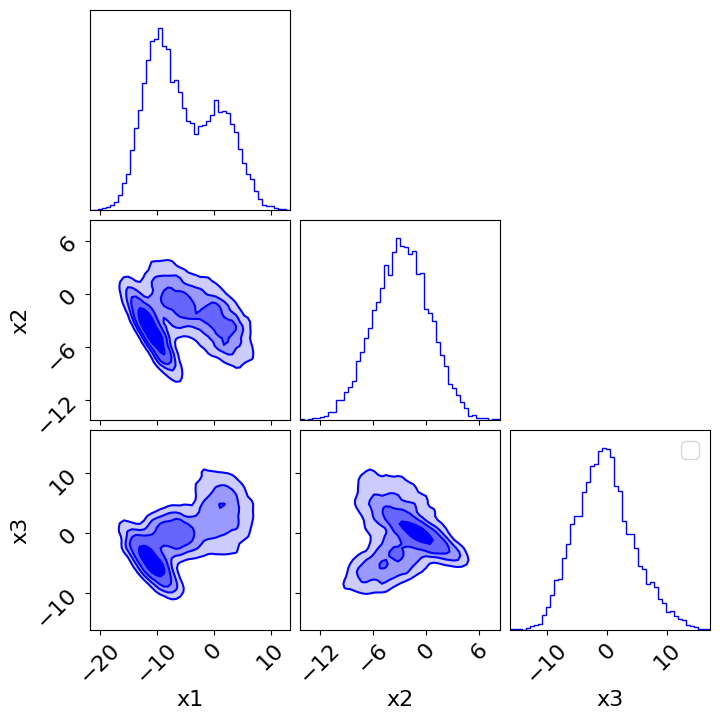

In [5]:
import numpy as np
import corner
import matplotlib.pyplot as plt

# make array 
true_np  = np.asarray(true_samples)   

# true plot
corner.corner(np.array(true_np), labels=[f'x{i+1}' for i in range(3)], **default_corner_kwargs)

plt.legend()
plt.show()

In [7]:
# define prior bounds for VI trainer
prior_bounds = dict(
            x0  = [-30.0, 10.0],
            x1  = [-25.0, 10.0],
            x2 = [-25.0, 15.0],
            )

# define tempering function for VI trainer
def cosine_temper(step, *, total_steps, beta_min=0.49):
    """
    Cosine annealing on [0, total_steps]:
        β(0) = 1      β(total_steps) = beta_min
    """
    t = step / total_steps
    return beta_min + 0.5 * (1 - beta_min) * (1 + jnp.cos(jnp.pi * t))

steps = 2000                          
temper_schedule = lambda s: cosine_temper(s,
                                          total_steps=steps,
                                          beta_min=0.7)

# optimization parameters
learning_rate = 0.03
learning_rate = optax.cosine_decay_schedule(learning_rate, steps)
optimizer = optax.adam(learning_rate)

# **5. Training VI approximation samples**

In [8]:
vi = VI(prior_bounds=prior_bounds, likelihood=likelihood)
key = random.key(0)


flow, losses = vi.trainer(           
    key=key,
    batch_size=1000,
    steps=steps,
    optimizer=optimizer,
    temper_schedule = temper_schedule,
    
)

GWAX - getting ready...
GWAX - JAX jitting...


GWAX - variational training: 100%|██████████| 2000/2000 [00:07<00:00, 253.68it/s]

GWAX: Total time = 8.989198684692383 s


In [9]:
# generate 10000 vi approxiamtion samples
vi_samples = np.array(flow.sample(jax.random.key(1), (10_000,)))
print("Number of samples:", len(vi_samples))
print("Samples:", vi_samples[0:5])

Number of samples: 10000
Samples: [[ 4.2326965  -1.6560917  -0.91228676]
 [-0.81588745 -4.240259    4.613407  ]
 [ 4.169647   -2.9319553  -0.2522564 ]
 [ 2.1397438  -6.8733997   2.3161545 ]
 [-0.4937458  -1.9282036   1.85989   ]]


# **6. Diagnostics of the results**

C:\Users\oleks\AppData\Local\Temp\ipykernel_37556\3661935638.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif
findfont: Generic family 'serif' not found because none of the following families were found: C

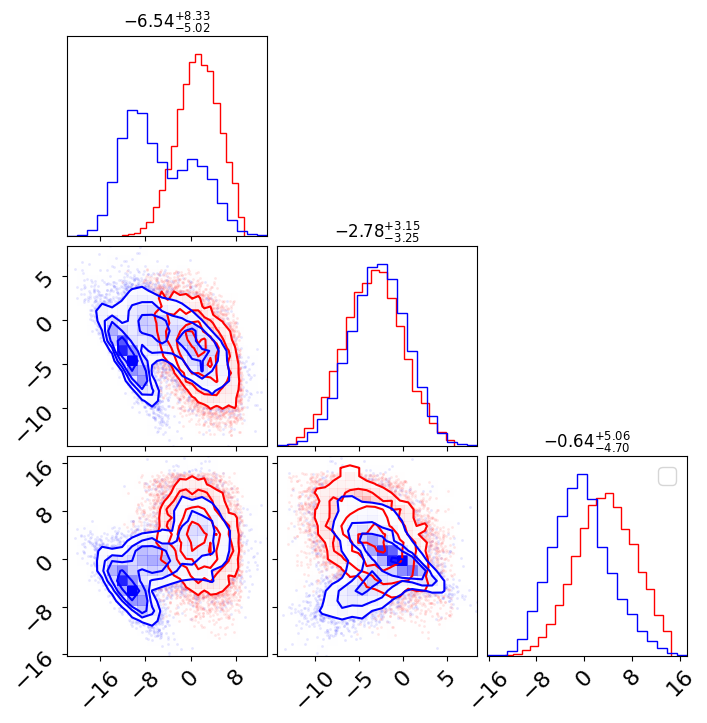

In [10]:
import numpy as np
import corner
import matplotlib.pyplot as plt

# make array 
vi_np    = np.asarray(vi_samples)      
true_np  = np.asarray(true_samples)    


# plot VI samples
hist_kwargs = {"color": "red", "density": True}
fig = corner.corner(vi_np, color="red", label="VI Approximation", hist_kwargs=hist_kwargs, show_titles=True)

# VI with true plot
hist_kwargs = {"color": "blue", "density": True}
corner.corner(true_np, fig=fig, color="blue", label="True Normal", hist_kwargs=hist_kwargs, show_titles=True)

plt.legend()
plt.show()


In [11]:
"""Here wew compute mean and variance for VI samples and specified true distribution in n dimensions"""

# mean and varianve across all dimensions of VI samples (axis=0 allows to catch all dimensions in our case)
pm = vi_samples.mean(axis=0)
pv = vi_samples.var(axis=0)

# mean and varianve across all dimensions of true normal
qm = true_samples.mean(axis=0)  
# or 
#qm = np.zeros(dim)
qv = true_samples.var(axis=0)   
# or 
# qv = np.ones(dim)


print("This is pm", pm)

print("This is pv", pv)

print("This is qm", qm)

print("This is qv", qv)

This is pm [ 1.2366873 -3.4288633  3.4677672]
This is pv [13.060394 10.896595 24.042122]
This is qm [-5.3888135  -2.8229463  -0.42070663]
This is qv [36.765427 10.070217 24.064253]


In [12]:
def gau_kl(pm, pv, qm, qv):
    """
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.
    The result is not bounded, if near 0, then distributions are symmetrical, if a big value, then distributions are different
    """
    if (len(qm.shape) == 2):
        axis = 1
    else:
        axis = 0
    # Determinants of diagonal covariances pv, qv
    dpv = pv.prod()
    dqv = qv.prod(axis)
    # Inverse of diagonal covariance qv
    iqv = 1./qv
    # Difference between means pm, qm
    diff = qm - pm
    return (0.5 *
            (np.log(dqv / dpv)            # log |\Sigma_q| / |\Sigma_p|
             + (iqv * pv).sum(axis)          # + tr(\Sigma_q^{-1} * \Sigma_p)
             + (diff * iqv * diff).sum(axis) # + (\mu_q-\mu_p)^T\Sigma_q^{-1}(\mu_q-\mu_p)
             - len(pm)))                     # - N

In [13]:
kl_div = gau_kl(pm, pv, qm, qv)
print(f"KL divergence between VI approximation and True Normal: {kl_div:.4f} nats")

KL divergence between VI approximation and True Normal: 1.1261 nats
